# Imports & Load Data
作業に必要なライブラリをインポートして、 以下のデータを読み込みます。

* stock_price : 株価情報
* stock_list : 銘柄情報
* stock_fin : 財務諸表
* stock_labels : 目的変数

In [2]:
# shap用にg++とgccをインストールします
! apt-get update
! apt-get install -y --no-install-recommends g++ gcc

# 必要なライブラリをインストールします
! pip install shap==0.37.0 slicer==0.0.3 xgboost==1.3.0.post0

Get:1 http://security.debian.org/debian-security stretch/updates InRelease [53.0 kB]
Ign:2 http://deb.debian.org/debian stretch InRelease   
Hit:3 http://deb.debian.org/debian stretch-updates InRelease
Hit:4 http://deb.debian.org/debian stretch Release 
Fetched 53.0 kB in 0s (98.6 kB/s)                  
Reading package lists... Done
Reading package lists... Done
Building dependency tree       
Reading state information... Done
g++ is already the newest version (4:6.3.0-4).
gcc is already the newest version (4:6.3.0-4).
0 upgraded, 0 newly installed, 0 to remove and 60 not upgraded.


In [3]:
import os
import pickle
import sys
import warnings
from glob import glob

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import shap
import xgboost
from scipy.stats import spearmanr
from sklearn.ensemble import (
    ExtraTreesRegressor,
    GradientBoostingRegressor,
    RandomForestRegressor,
)
from sklearn.metrics import accuracy_score, mean_squared_error
from tqdm.auto import tqdm


# 表示用の設定を変更します
%matplotlib inline
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100
pd.options.display.width = 120

In [4]:
# python 3.7.3であることを確認します
import sys
print(sys.version)

3.7.3 (default, Mar 27 2019, 22:11:17) 
[GCC 7.3.0]


In [5]:
# データセット保存先ディレクトリ（""の中身はご自身の環境に合わせて定義してください。）
dataset_dir="/path/to"

In [6]:
# 読み込むファイルを定義します。
inputs = {
    "stock_list": f"{dataset_dir}/stock_list.csv.gz",
    "stock_price": f"{dataset_dir}/stock_price.csv.gz",
    "stock_fin": f"{dataset_dir}/stock_fin.csv.gz",
    # 本チュートリアルでは使用しないため、コメントアウトしています。
    # "stock_fin_price": f"{dataset_dir}/stock_fin_price.csv.gz",
    "stock_labels": f"{dataset_dir}/stock_labels.csv.gz",
}

# ファイルを読み込みます
dfs = {}
for k, v in inputs.items():
    print(k)
    dfs[k] = pd.read_csv(v)

stock_list
stock_price
stock_fin
stock_labels


# 欠損値処理

(64421, 44)
base_date                                                         0
Local Code                                                        0
Result_FinancialStatement AccountingStandard                    239
Result_FinancialStatement FiscalPeriodEnd                       239
Result_FinancialStatement ReportType                            239
Result_FinancialStatement FiscalYear                            239
Result_FinancialStatement ModifyDate                            239
Result_FinancialStatement CompanyType                           239
Result_FinancialStatement ChangeOfFiscalYearEnd                 239
Result_FinancialStatement NetSales                              256
Result_FinancialStatement OperatingIncome                      2072
Result_FinancialStatement OrdinaryIncome                        308
Result_FinancialStatement NetIncome                             242
Result_FinancialStatement TotalAssets                           240
Result_FinancialStatement NetAssets 

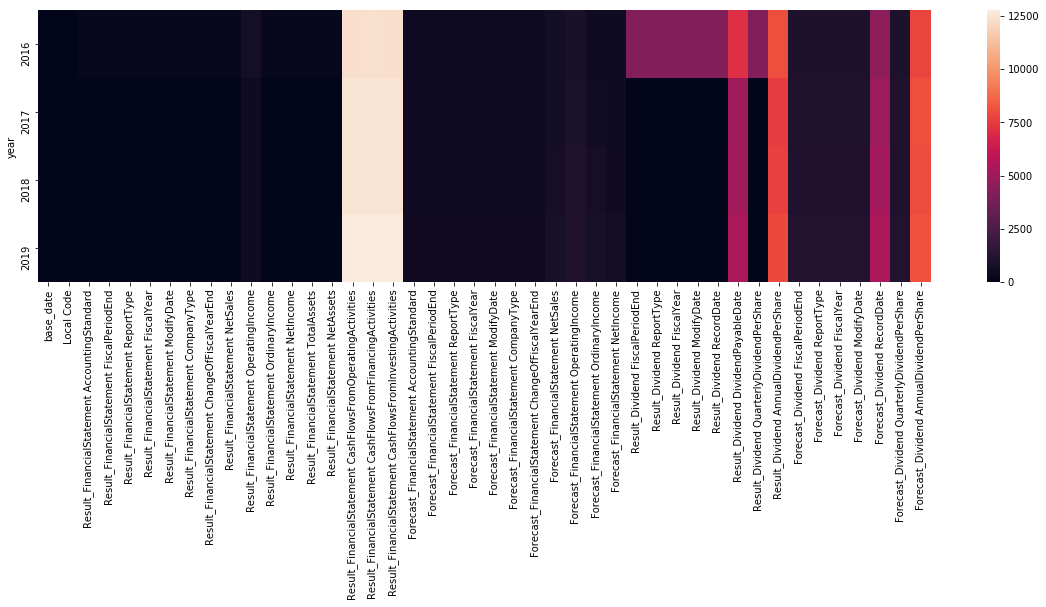

In [6]:
# stock_finデータを読み込む
stock_fin = dfs["stock_fin"].copy()

# 日付列をpd.Timestamp型に変換してindexに設定
stock_fin["datetime"] = pd.to_datetime(stock_fin["base_date"])
stock_fin.set_index("datetime", inplace=True)
# 2019年までの値を表示
stock_fin = stock_fin[:"2019"]

# データ数の確認
print(stock_fin.shape)

# データの欠損値数を確認
print(stock_fin.isna().sum())

# 欠損値の数を年別に集計
stock_fin = stock_fin.isna()
stock_fin["year"] = stock_fin.index.year

# データの欠損値をプロット
fig, ax = plt.subplots(figsize=(20, 5))
sns.heatmap(stock_fin.groupby("year").agg("sum"), ax=ax)

In [7]:
COLUMNS = ['Result_FinancialStatement FiscalYear', 'Result_FinancialStatement NetSales',
       'Result_FinancialStatement OperatingIncome', 'Result_FinancialStatement OrdinaryIncome',
       'Result_FinancialStatement NetIncome', 'Result_FinancialStatement TotalAssets',
       'Result_FinancialStatement NetAssets', 'Result_FinancialStatement CashFlowsFromOperatingActivities',
       'Result_FinancialStatement CashFlowsFromFinancingActivities',
       'Result_FinancialStatement CashFlowsFromInvestingActivities', 'Forecast_FinancialStatement FiscalYear',
       'Forecast_FinancialStatement NetSales', 'Forecast_FinancialStatement OperatingIncome',
       'Forecast_FinancialStatement OrdinaryIncome', 'Forecast_FinancialStatement NetIncome',
       'Result_Dividend FiscalYear', 'Result_Dividend QuarterlyDividendPerShare',
       'Result_Dividend AnnualDividendPerShare', 'Forecast_Dividend FiscalYear',
       'Forecast_Dividend QuarterlyDividendPerShare', 'Forecast_Dividend AnnualDividendPerShare',
       'IssuedShareEquityQuote IssuedShare','Section/Products', '33 Sector(Code)', '17 Sector(Code)']

In [8]:
section_products = {
    "First Section (Domestic)" : 1,
    "JASDAQ(Standard / Domestic)" :2,
    "Second Section(Domestic)" :3,
    "Mothers (Domestic)" : 4,
    "JASDAQ(Growth/Domestic)" :5
}

In [33]:
def calculate_glossary_of_financial_analysis(row):
    operating_profit_margin = -999
    ordinary_profit_margin = -999
    net_profit_margin = -999
    total_asset_turnover = -999
    net_sales_growth_rate = -999
    ordinary_income_growth_rate = -999
    operationg_income_growth_rate = -999
    total_assets_growth_rate = -999
    net_assets_growth_rate = -999
    eps = -999
    bps = -999
    roe = -999

    # 売上高営業利益率 売上高営業利益率（％）＝営業利益÷売上高×100
    if row['Result_FinancialStatement NetSales'] != 0:
        operating_profit_margin = \
            row['Result_FinancialStatement OperatingIncome'] / \
            row['Result_FinancialStatement NetSales'] * 100
    # 売上高経常利益率　売上高経常利益率（％）＝経常利益÷売上高×100
    if row['Result_FinancialStatement NetSales'] != 0:
        ordinary_profit_margin = \
            row['Result_FinancialStatement OrdinaryIncome'] / \
            row['Result_FinancialStatement NetSales'] * 100
    # 売上高純履歴率　売上高純利益率（％）＝当期純利益÷売上高×100
    if row['Result_FinancialStatement NetSales'] != 0:
        net_profit_margin = row['Result_FinancialStatement NetIncome'] / \
                            row['Result_FinancialStatement NetSales'] * 100
    # 総資本回転率 総資本回転率（％）＝売上高÷総資本（自己資本＋他人資本）×100
    if row['Result_FinancialStatement NetAssets'] != 0:
        total_asset_turnover = row['Result_FinancialStatement NetSales'] / \
                            row['Result_FinancialStatement NetAssets'] * 100
    # 売上高増加率
    if row['Previous_FinancialStatement NetSales'] != 0:
        net_sales_growth_rate = \
            (row['Result_FinancialStatement NetSales'] -
            row['Previous_FinancialStatement NetSales']) / \
            row['Previous_FinancialStatement NetSales'] * 100
    # 経常利益増加率
    if row['Previous_FinancialStatement OrdinaryIncome'] != 0:
        ordinary_income_growth_rate = \
            (row['Result_FinancialStatement OrdinaryIncome'] -
            row['Previous_FinancialStatement OrdinaryIncome']) / \
            row['Previous_FinancialStatement OrdinaryIncome'] * 100

    # 営業利益増加率
    if row['Previous_FinancialStatement OperatingIncome'] != 0:
        operationg_income_growth_rate = \
            (row['Result_FinancialStatement OperatingIncome'] -
            row['Previous_FinancialStatement OperatingIncome']) / \
            row['Previous_FinancialStatement OperatingIncome'] * 100
    # 総資本増加率
    if row['Previous_FinancialStatement TotalAssets'] != 0:
        total_assets_growth_rate = \
            (row['Result_FinancialStatement TotalAssets'] -
            row['Previous_FinancialStatement TotalAssets']) / \
            row['Previous_FinancialStatement TotalAssets'] * 100
    # 純資本増加率
    if row['Previous_FinancialStatement NetAssets'] != 0:
        net_assets_growth_rate = \
            (row['Result_FinancialStatement NetAssets'] -
            row['Previous_FinancialStatement NetAssets']) / \
            row['Previous_FinancialStatement NetAssets'] * 100
    # 一株当たり当期純利益（EPS）
    if row['IssuedShareEquityQuote IssuedShare'] != 0:
        eps = row['Result_FinancialStatement NetIncome'] / \
            row['IssuedShareEquityQuote IssuedShare']
        # BPS 一株当たり純資産（円） ＝ 純資産 ÷ 発行済株式総数
        bps = row['Result_FinancialStatement NetAssets'] / \
            row['IssuedShareEquityQuote IssuedShare']
        # ROE EPS（一株当たり利益）÷ BPS（一株当たり純資産）× 100
        if bps > 0:
            roe = eps / bps * 100
    return pd.Series(
        [operating_profit_margin, ordinary_profit_margin,
            net_profit_margin, total_asset_turnover,
            net_sales_growth_rate, ordinary_income_growth_rate,
            operationg_income_growth_rate, total_assets_growth_rate,
            net_assets_growth_rate, eps, bps, roe])

# 特徴量の生成

In [34]:
TRAIN_END = "2017-12-31"
VAL_START = "2018-02-01"
VAL_END = "2018-12-01"
TEST_START = "2019-01-01"

In [35]:
def get_features_for_predict(dfs, code):
    """
    Args:
        dfs (dict)  : dict of pd.DataFrame include stock_fin, stock_price
        code (int)  : A local code for a listed company
    Returns:
        feature DataFrame (pd.DataFrame)
    """
    # おおまかな手順の1つ目
    # stock_finデータを読み込み
    stock_fin = dfs["stock_fin"].copy()
    
    stock_list = dfs["stock_list"].copy()
    stock_fin = pd.merge(stock_fin, stock_list, on=["Local Code"] )

    # 特定の銘柄コードのデータに絞る
    fin_data = stock_fin[stock_fin["Local Code"] == code].copy()
    # 日付列をpd.Timestamp型に変換してindexに設定
    fin_data["datetime"] = pd.to_datetime(fin_data["base_date"])
    fin_data.set_index("datetime", inplace=True)
    # fin_dataを選択
    fin_data = fin_data[COLUMNS]
    fin_data = fin_data.join(fin_data[['Result_FinancialStatement NetSales', 'Result_FinancialStatement OperatingIncome', 
                                   'Result_FinancialStatement OrdinaryIncome', 'Result_FinancialStatement NetIncome', 
                                   'Result_FinancialStatement TotalAssets', 'Result_FinancialStatement NetAssets',
                                   'Result_FinancialStatement CashFlowsFromOperatingActivities', 
                                   'Result_FinancialStatement CashFlowsFromFinancingActivities',
                                   'Result_FinancialStatement CashFlowsFromInvestingActivities']].rename(columns =
                                                                                                         {'Result_FinancialStatement NetSales': 'Previous_FinancialStatement NetSales',
                                                                                                          'Result_FinancialStatement OperatingIncome': 'Previous_FinancialStatement OperatingIncome', 
                                                                                                          'Result_FinancialStatement OrdinaryIncome': 'Previous_FinancialStatement OrdinaryIncome', 
                                                                                                          'Result_FinancialStatement NetIncome':'Previous_FinancialStatement NetIncome', 
                                                                                                          'Result_FinancialStatement TotalAssets': 'Previous_FinancialStatement TotalAssets', 
                                                                                                          'Result_FinancialStatement NetAssets':'Previous_FinancialStatement NetAssets',
                                                                                                          'Result_FinancialStatement CashFlowsFromOperatingActivities': 'Previous_FinancialStatement CashFlowsFromOperatingActivities', 
                                                                                                          'Result_FinancialStatement CashFlowsFromFinancingActivities':'Previous_FinancialStatement CashFlowsFromFinancingActivities',
                                                                                                          'Result_FinancialStatement CashFlowsFromInvestingActivities':'Previous_FinancialStatement CashFlowsFromInvestingActivities'}).shift(-1))
    fin_data[['operating_profit_margin', 'ordinary_profit_margin', 'net_profit_margin', 'total_asset_turnover',
         'net_sales_growth_rate', 'ordinary_income_growth_rate', 'operationg_income_growth_rate',
          'total_assets_growth_rate', 'net_assets_growth_rate', 'eps', 'bps', 'roe']] = fin_data.apply(calculate_glossary_of_financial_analysis, axis=1)

    # 欠損値処理
    fin_feats = fin_data.fillna(-999)

    # おおまかな手順の2つ目
    # stock_priceデータを読み込む
    price = dfs["stock_price"].copy()
    # 特定の銘柄コードのデータに絞る
    price_data = price[price["Local Code"] == code].copy()
    # 日付列をpd.Timestamp型に変換してindexに設定
    price_data["datetime"] = pd.to_datetime(price_data["EndOfDayQuote Date"])
    price_data.set_index("datetime", inplace=True)
    # 終値のみに絞る
    feats = price_data[["EndOfDayQuote ExchangeOfficialClose"]].copy()
    # 終値の20営業日リターン
    feats["return_1month"] = feats["EndOfDayQuote ExchangeOfficialClose"].pct_change(20)
    # 終値の40営業日リターン
    feats["return_2month"] = feats["EndOfDayQuote ExchangeOfficialClose"].pct_change(40)
    # 終値の60営業日リターン
    feats["return_3month"] = feats["EndOfDayQuote ExchangeOfficialClose"].pct_change(60)
    # 終値の20営業日ボラティリティ
    feats["volatility_1month"] = (
        np.log(feats["EndOfDayQuote ExchangeOfficialClose"]).diff().rolling(20).std()
    )
    # 終値の40営業日ボラティリティ
    feats["volatility_2month"] = (
        np.log(feats["EndOfDayQuote ExchangeOfficialClose"]).diff().rolling(40).std()
    )
    # 終値の60営業日ボラティリティ
    feats["volatility_3month"] = (
        np.log(feats["EndOfDayQuote ExchangeOfficialClose"]).diff().rolling(60).std()
    )
    # 終値と20営業日の単純移動平均線の乖離
    feats["MA_gap_1month"] = feats["EndOfDayQuote ExchangeOfficialClose"] / (
        feats["EndOfDayQuote ExchangeOfficialClose"].rolling(20).mean()
    )
    # 終値と40営業日の単純移動平均線の乖離
    feats["MA_gap_2month"] = feats["EndOfDayQuote ExchangeOfficialClose"] / (
        feats["EndOfDayQuote ExchangeOfficialClose"].rolling(40).mean()
    )
    # 終値と60営業日の単純移動平均線の乖離
    feats["MA_gap_3month"] = feats["EndOfDayQuote ExchangeOfficialClose"] / (
        feats["EndOfDayQuote ExchangeOfficialClose"].rolling(60).mean()
    )
    
    # EWMA
    ALPHA = 0.25
    feats["EWMA"] = feats["EndOfDayQuote ExchangeOfficialClose"]

    for t in zip(feats.index, feats.index[1:]):
        feats.loc[t[1], "EWMA"] = ALPHA * feats.loc[t[1], "EndOfDayQuote ExchangeOfficialClose"] + (1 - ALPHA) * feats.loc[t[0], "EWMA"]
    
    # EMA 10日
    feats["ema_10"] = feats["EndOfDayQuote ExchangeOfficialClose"].ewm(span=10).mean()
    
    # MACD 
    # EMA12
    feats["ema_12"] = feats["EndOfDayQuote ExchangeOfficialClose"].ewm(span=12).mean()
    # EMA 26
    feats["ema_26"] = feats["EndOfDayQuote ExchangeOfficialClose"].ewm(span=26).mean()
    feats["macd"] = feats["ema_12"] - feats["ema_26"]
    feats["signal"] = feats["macd"].ewm(span=9).mean()
    
    # PBR 株価 ÷ BPS（1株あたり純資産）
    feats["pbr"] = feats["EndOfDayQuote ExchangeOfficialClose"] / fin_data["bps"]
    # PER 株価 ÷ 1株当たり利益（EPS）
    feats["per"] = feats["EndOfDayQuote ExchangeOfficialClose"] / fin_data["eps"]

    # おおまかな手順の3つ目
    # 欠損値処理
    feats = feats.fillna(-999)
    # 元データのカラムを削除
    feats = feats.drop(["EndOfDayQuote ExchangeOfficialClose"], axis=1)

    # 財務データの特徴量とマーケットデータの特徴量のインデックスを合わせる
    feats = feats.loc[feats.index.isin(fin_feats.index)]
    fin_feats = fin_feats.loc[fin_feats.index.isin(feats.index)]

    # データを結合
    feats = pd.concat([feats, fin_feats], axis=1).dropna()

    # 欠損値処理を行います。
    feats = feats.replace([np.inf, -np.inf], -999)
    
    # 市場・商品区分を数値に変換
    feats["Section/Products"] = section_products[feats["Section/Products"][0]]
    # 銘柄コードを設定
    feats["code"] = code

    return feats

In [36]:
def get_features_and_label(dfs, codes, feature, label):
    """
    Args:
        dfs (dict[pd.DataFrame]): loaded data
        codes  (array) : target codes
        feature (pd.DataFrame): features
        label (str) : label column name
    Returns:
        train_X (pd.DataFrame): training data
        train_y (pd.DataFrame): label for train_X
        val_X (pd.DataFrame): validation data
        val_y (pd.DataFrame): label for val_X
        test_X (pd.DataFrame): test data
        test_y (pd.DataFrame): label for test_X
    """
    # 分割データ用の変数を定義
    trains_X, vals_X, tests_X = [], [], []
    trains_y, vals_y, tests_y = [], [], []

    # 銘柄コード毎に特徴量を作成
    for code in tqdm(codes):
        # 特徴量取得
        feats = feature[feature["code"] == code]

        # stock_labelデータを読み込み
        stock_labels = dfs["stock_labels"].copy()
        # 特定の銘柄コードのデータに絞る
        stock_labels = stock_labels[stock_labels["Local Code"] == code]
        # 日付列をpd.Timestamp型に変換してindexに設定
        stock_labels["datetime"] = pd.to_datetime(stock_labels["base_date"])
        stock_labels.set_index("datetime", inplace=True)

        # 特定の目的変数に絞る
        labels = stock_labels[label]
        # nanを削除
        labels.dropna(inplace=True)

        if feats.shape[0] > 0 and labels.shape[0] > 0:
            # 特徴量と目的変数のインデックスを合わせる
            labels = labels.loc[labels.index.isin(feats.index)]
            feats = feats.loc[feats.index.isin(labels.index)]
            labels.index = feats.index

            # データを分割（ホールドアウト法）
            _train_X = feats[: TRAIN_END].copy()
            _val_X = feats[VAL_START : VAL_END].copy()
            _test_X = feats[TEST_START :].copy()

            _train_y = labels[: TRAIN_END].copy()
            _val_y = labels[VAL_START : VAL_END].copy()
            _test_y = labels[TEST_START :].copy()

            # データを配列に格納 (後ほど結合するため)
            trains_X.append(_train_X)
            vals_X.append(_val_X)
            tests_X.append(_test_X)

            trains_y.append(_train_y)
            vals_y.append(_val_y)
            tests_y.append(_test_y)

    # 銘柄毎に作成した説明変数データを結合します。
    train_X = pd.concat(trains_X)
    val_X = pd.concat(vals_X)
    test_X = pd.concat(tests_X)
    # 銘柄毎に作成した目的変数データを結合します。
    train_y = pd.concat(trains_y)
    val_y = pd.concat(vals_y)
    test_y = pd.concat(tests_y)

    return train_X, train_y, val_X, val_y, test_X, test_y

In [37]:
# 対象銘柄コードを定義
codes = [9984]
# 対象の目的変数を定義
label = "label_high_20"
# 特徴量を取得
feat = get_features_for_predict(dfs, codes[0])
# 特徴量と目的変数を入力し、分割データを取得
ret = get_features_and_label(dfs, codes, feat, label)
for v in ret:
    print(v.T)

datetime                                              2016-02-10    2016-04-21    2016-05-10    2016-07-28  \
return_1month                                      -1.913212e-01  8.908766e-02  8.688554e-02 -7.610193e-02   
return_2month                                      -9.990000e+02  1.441458e-01  2.409844e-02 -1.417147e-01   
return_3month                                      -9.990000e+02  2.555166e-01  1.739812e-01 -1.038744e-01   
volatility_1month                                   4.402584e-02  1.717726e-02  2.271106e-02  3.175834e-02   
volatility_2month                                  -9.990000e+02  1.705030e-02  1.818629e-02  3.062359e-02   
volatility_3month                                  -9.990000e+02  3.428422e-02  3.271347e-02  2.758085e-02   
MA_gap_1month                                       9.107187e-01  1.071322e+00  1.008618e+00  9.588478e-01   
MA_gap_2month                                      -9.990000e+02  1.067462e+00  1.037082e+00  9.375874e-01   
MA_gap_3mo

In [38]:
def get_codes(dfs):
    """
    Args:
        dfs (dict[pd.DataFrame]): loaded data
    Returns:
        array: list of stock codes
    """
    stock_list = dfs["stock_list"].copy()
    # 予測対象の銘柄コードを取得
    codes = stock_list[stock_list["prediction_target"] == True][
        "Local Code"
    ].values
    return codes

In [39]:
# 対象の目的変数を定義
labels = {
    "label_high_5",
    "label_high_10",
    "label_high_20",
    "label_low_5",
    "label_low_10",
    "label_low_20",
}
# 目的変数毎にデータを保存するための変数
train_X, val_X, test_X = {}, {}, {}
train_y, val_y, test_y = {}, {}, {}

# 予測対象銘柄を取得
codes = get_codes(dfs)

# 特徴量を作成
buff = []
for code in tqdm(codes):
    feat = get_features_for_predict(dfs, code)
    buff.append(feat)
feature = pd.concat(buff)

# 目的変数毎に処理
for label in tqdm(labels):
    # 特徴量と目的変数を取得
    _train_X, _train_y, _val_X, _val_y, _test_X, _test_y = get_features_and_label(dfs, codes, feature, label)
    # 目的変数をキーとして値を保存
    train_X[label] = _train_X
    val_X[label] = _val_X
    test_X[label] = _test_X
    train_y[label] = _train_y
    val_y[label] = _val_y
    test_y[label] = _test_y

In [40]:
# 目的変数を指定
label = "label_high_20"
# モデルの初期化
pred_model = RandomForestRegressor(random_state=0)
# モデルの学習
pred_model.fit(train_X[label], train_y[label])

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [60]:
COLUMNS

['Result_FinancialStatement FiscalYear',
 'Result_FinancialStatement NetSales',
 'Result_FinancialStatement OperatingIncome',
 'Result_FinancialStatement OrdinaryIncome',
 'Result_FinancialStatement NetIncome',
 'Result_FinancialStatement TotalAssets',
 'Result_FinancialStatement NetAssets',
 'Result_FinancialStatement CashFlowsFromOperatingActivities',
 'Result_FinancialStatement CashFlowsFromFinancingActivities',
 'Result_FinancialStatement CashFlowsFromInvestingActivities',
 'Forecast_FinancialStatement FiscalYear',
 'Forecast_FinancialStatement NetSales',
 'Forecast_FinancialStatement OperatingIncome',
 'Forecast_FinancialStatement OrdinaryIncome',
 'Forecast_FinancialStatement NetIncome',
 'Result_Dividend FiscalYear',
 'Result_Dividend QuarterlyDividendPerShare',
 'Result_Dividend AnnualDividendPerShare',
 'Forecast_Dividend FiscalYear',
 'Forecast_Dividend QuarterlyDividendPerShare',
 'Forecast_Dividend AnnualDividendPerShare',
 'IssuedShareEquityQuote IssuedShare',
 'Section/Pr

In [64]:
fin_data.T

datetime,2016-02-10 00:00:00,2016-04-21 00:00:00,2016-05-10 00:00:00,2016-07-28 00:00:00,2016-11-07 00:00:00,2017-02-08 00:00:00,2017-05-10 00:00:00,2017-08-07 00:00:00,2017-11-06 00:00:00,2018-02-07 00:00:00,2018-05-09 00:00:00,2018-08-06 00:00:00,2018-11-05 00:00:00,2019-02-06 00:00:00,2019-05-09 00:00:00,2019-08-07 00:00:00,2019-11-06 00:00:00,2020-02-12 00:00:00,2020-04-13 00:00:00,2020-04-30 00:00:00,2020-05-18 00:00:00,2020-08-11 00:00:00,2020-10-23 00:00:00,2020-11-09 00:00:00
Result_FinancialStatement FiscalYear,2016,2016,2016,2017,2017,2017,2017,2018,2018,2018,2018,2019,2019,2019,2019,2020,2020,2020,2020,2020,2020,2021,2021,2021
Result_FinancialStatement NetSales,6.81021e+06,6.81021e+06,9.15355e+06,2.12652e+06,4.27183e+06,6.58147e+06,8.901e+06,2.18606e+06,4.41114e+06,6.81127e+06,9.15876e+06,2.27278e+06,4.65385e+06,7.16845e+06,9.60224e+06,2.3364e+06,4.65172e+06,7.0898e+06,7.0898e+06,7.0898e+06,6.18509e+06,1.45006e+06,1.45006e+06,2.63053e+06
Result_FinancialStatement OperatingIncome,875322,875322,999488,319236,653944,949660,1.026e+06,479273,874839,1.14883e+06,1.3038e+06,714993,1.42072e+06,1.85901e+06,2.35393e+06,688816,-15552,-12964,-12964,-12964,-1.36463e+06,NaN,NaN,NaN
Result_FinancialStatement OrdinaryIncome,918214,918214,1.00576e+06,356361,665625,975257,712526,77568,219021,563804,384630,572304,1.40209e+06,1.80983e+06,1.6913e+06,1.68234e+06,1.1169e+06,1.34538e+06,1.34538e+06,1.34538e+06,35492,833047,833047,1.44147e+06
Result_FinancialStatement NetIncome,428972,428972,474172,254157,766249,857431,1.42631e+06,5521,102622,1.01494e+06,1.03898e+06,313687,840103,1.5384e+06,1.4112e+06,1.12172e+06,421552,476587,476587,476587,-961576,1.25571e+06,1.25571e+06,1.88321e+06
Result_FinancialStatement TotalAssets,2.14976e+07,2.14976e+07,2.07072e+07,2.06222e+07,2.28961e+07,2.4867e+07,2.46342e+07,2.48831e+07,2.79735e+07,2.94127e+07,3.11805e+07,3.22684e+07,3.38076e+07,3.64595e+07,3.60965e+07,3.6587e+07,3.68487e+07,3.94064e+07,3.94064e+07,3.94064e+07,3.72573e+07,3.35633e+07,3.35633e+07,3.56482e+07
Result_FinancialStatement NetAssets,3.85551e+06,3.85551e+06,3.50527e+06,3.272e+06,3.12632e+06,3.98171e+06,4.46973e+06,4.65475e+06,5.46837e+06,6.56888e+06,6.27302e+06,6.82117e+06,7.34314e+06,9.28639e+06,9.0092e+06,9.44533e+06,8.62363e+06,9.19142e+06,9.19142e+06,9.19142e+06,7.37292e+06,7.57678e+06,7.57678e+06,8.42060e+06
Result_FinancialStatement CashFlowsFromOperatingActivities,NaN,NaN,940186,NaN,NaN,NaN,1.50073e+06,NaN,NaN,NaN,1.08862e+06,NaN,NaN,NaN,1.17186e+06,NaN,NaN,NaN,NaN,NaN,1.11788e+06,NaN,NaN,NaN
Result_FinancialStatement CashFlowsFromFinancingActivities,NaN,NaN,43270,NaN,NaN,NaN,2.38075e+06,NaN,NaN,NaN,4.62642e+06,NaN,NaN,NaN,2.20229e+06,NaN,NaN,NaN,NaN,NaN,2.92086e+06,NaN,NaN,NaN
Result_FinancialStatement CashFlowsFromInvestingActivities,NaN,NaN,-1.65168e+06,NaN,NaN,NaN,-4.2136e+06,NaN,NaN,NaN,-4.48482e+06,NaN,NaN,NaN,-2.90802e+06,NaN,NaN,NaN,NaN,NaN,-4.28692e+06,NaN,NaN,NaN


In [63]:
technical_cols

['return_1month',
 'return_2month',
 'return_3month',
 'volatility_1month',
 'volatility_2month',
 'volatility_3month',
 'MA_gap_1month',
 'MA_gap_2month',
 'MA_gap_3month',
 'EWMA',
 'ema_10',
 'ema_12',
 'ema_26',
 'macd',
 'signal',
 'pbr',
 'per',
 'Section/Products',
 '33 Sector(Code)',
 '17 Sector(Code)']

In [62]:
# モデルを定義
models = {
    "rf": RandomForestRegressor,
}

# モデルを選択
model = "rf"

# 目的変数を指定
label = "label_high_20"

# 学習用データセット定義
# ファンダメンタル情報
#fundamental_cols = dfs["stock_fin"].select_dtypes("float64").columns
fundamental_cols = fin_data.select_dtypes("float64").columns
fundamental_cols = fundamental_cols[fundamental_cols != "Result_Dividend DividendPayableDate"]
fundamental_cols = fundamental_cols[fundamental_cols != "Local Code"]
# 価格変化率
returns_cols = [x for x in train_X[label].columns if "return" in x]
# テクニカル
technical_cols = [x for x in train_X[label].columns if (x not in fundamental_cols) and (x != "code")]

columns = {
    "fundamental_only": fundamental_cols,
    "return_only": returns_cols,
    "technical_only": technical_cols,
    "fundamental+technical": list(fundamental_cols) + list(technical_cols),
}
# 学習用データセットを指定
col = "fundamental_only"

# 学習
pred_model = models[model](random_state=0)
pred_model.fit(train_X[label][columns[col]].values, train_y[label])

# 予測
result = {}
result[label] = pd.DataFrame(
    pred_model.predict(val_X[label][columns[col]]), columns=["predict"]
)

# 予測結果に日付と銘柄コードを追加
result[label]["datetime"] = val_X[label][columns[col]].index
result[label]["code"] = val_X[label]["code"].values

# 予測の符号を取得
result[label]["predict_dir"] = np.sign(result[label]["predict"])

# 実際の値を追加
result[label]["actual"] = val_y[label].values

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.


# Submit Model

In [45]:
model_path = os.path.join(os.path.dirname("__file__"), "../model")
# tag::save_model[]
# モデル保存先ディレクトリを作成
os.makedirs(model_path, exist_ok=True)
with open(os.path.join(model_path, f"my_model_{label}.pkl"), "wb") as f:
    # モデルをpickle形式で保存
    pickle.dump(pred_model, f)


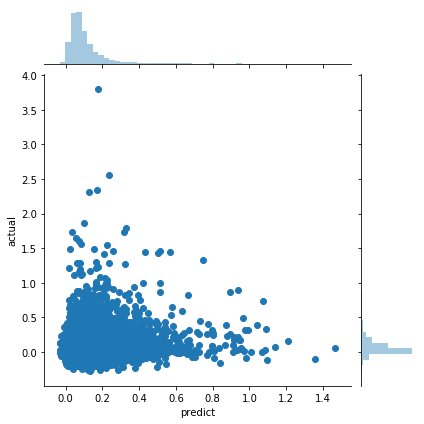

In [46]:
sns.jointplot(data=result[label], x="predict", y="actual")

In [47]:
pred_model

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

Text(0.5, 0, 'Random Forest Feature Importance')

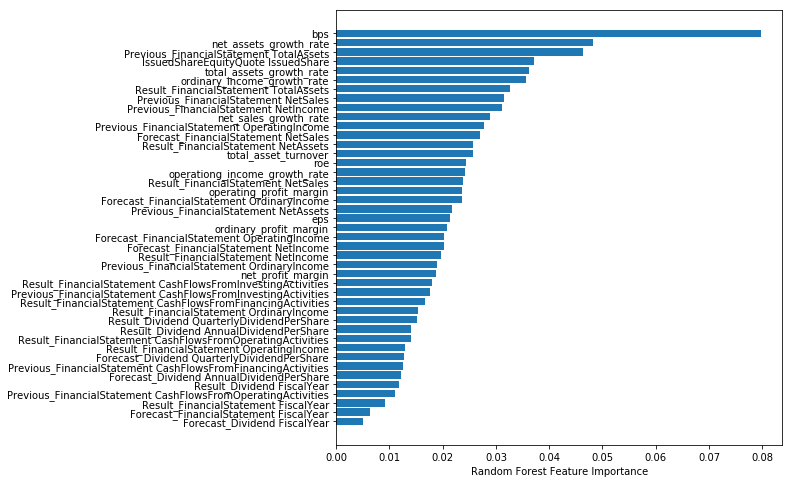

In [48]:
# 学習済みモデルを指定
rf = pred_model

# 重要度順を取得
sorted_idx = rf.feature_importances_.argsort()
# プロット
fig, ax = plt.subplots(figsize=(8, 8))
ax.barh(fundamental_cols[sorted_idx], rf.feature_importances_[sorted_idx])
ax.set_xlabel("Random Forest Feature Importance")

In [49]:
# モデルを定義します
sample_model = xgboost.train({"learning_rate": 0.01}, xgboost.DMatrix(train_X["label_high_20"], label=train_y["label_high_20"]), 100)

model_output = "margin" has been renamed to model_output = "raw"


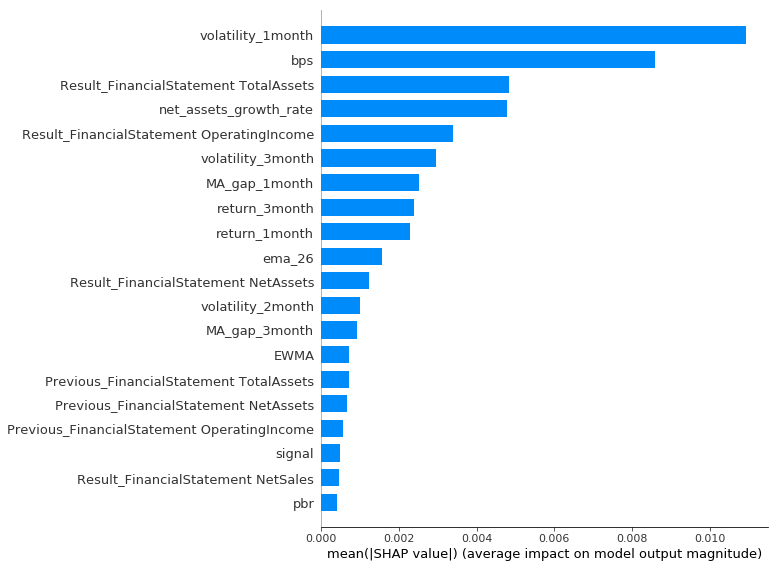

In [50]:
shap.initjs()
explainer = shap.TreeExplainer(model=sample_model, feature_perturbation='tree_path_dependent', model_output='margin')
# SHAP値
shap_values = explainer.shap_values(X=train_X["label_high_20"])
# プロット
shap.summary_plot(shap_values, train_X["label_high_20"], plot_type="bar")

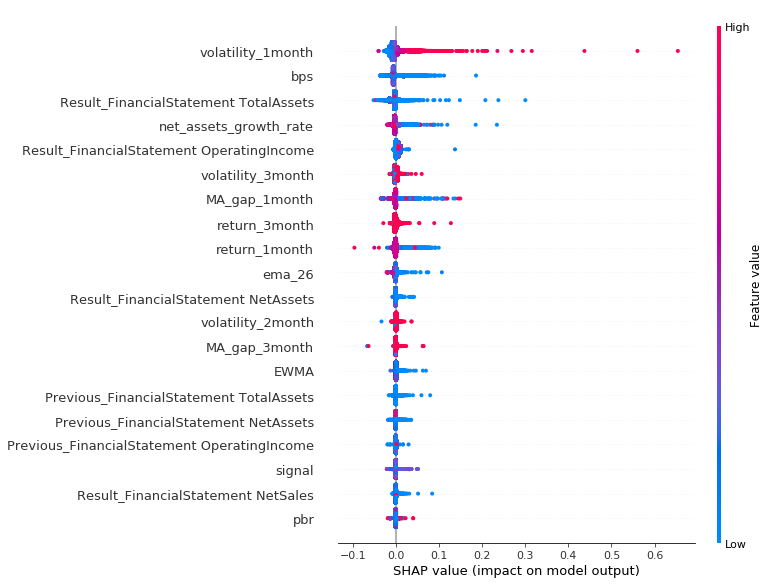

In [51]:
shap.summary_plot(shap_values, train_X["label_high_20"])

In [52]:
# モデルを定義
models = {
    "rf": RandomForestRegressor,
    "extraTree": ExtraTreesRegressor,
    "gbr": GradientBoostingRegressor,
}

# 学習用データセット定義
columns = {
    "fundamental_only": fundamental_cols,
    "return_only": returns_cols,
    "technical_only": technical_cols,
    "fundamental+technical": list(fundamental_cols) + list(technical_cols),
}

# 結果保存用
all_results = dict()
# モデル毎に処理
for model in tqdm(models.keys()):
    all_results[model] = dict()
    # データセット毎に処理
    for col in columns.keys():
        result = dict()
        # 目的変数毎に処理
        for label in tqdm(labels):
            if len(test_X[label][columns[col]]) > 0:
                # モデル取得
                pred_model = models[model](random_state=0)
                # 学習
                pred_model.fit(train_X[label][columns[col]].values, train_y[label])
                # 結果データ作成
                result[label] = test_X[label][["code"]].copy()
                result[label]["datetime"] = test_X[label][columns[col]].index
                # 予測
                result[label]["predict"] = pred_model.predict(test_X[label][columns[col]])
                result[label]["predict_dir"] = np.sign(result[label]["predict"])
                # 実際の結果
                result[label]["actual"] = test_y[label].values
                result[label]["actual_dir"] = np.sign(result[label]["actual"])
                result[label].dropna(inplace=True)

        all_results[model][col] = result

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.


The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.


The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.


The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.


The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.


The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.


The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.


The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.


In [53]:
results = []
for model in all_results.keys():
    for col in all_results[model]:
        tmp = pd.concat(all_results[model][col])
        tmp["model"] = model
        tmp["feature"] = col
        results.append(tmp)
results = pd.concat(results)
results["label"] = [x[0] for x in results.index]
results.head(5)

code   datetime   predict  predict_dir   actual  actual_dir model           feature  \
              datetime                                                                                          
label_high_10 2019-02-08  1301 2019-02-08  0.088536          1.0  0.07143         1.0    rf  fundamental_only   
              2019-05-13  1301 2019-05-13  0.059628          1.0  0.04379         1.0    rf  fundamental_only   
              2019-08-02  1301 2019-08-02  0.042958          1.0  0.00498         1.0    rf  fundamental_only   
              2019-11-05  1301 2019-11-05  0.071258          1.0  0.00841         1.0    rf  fundamental_only   
              2020-02-07  1301 2020-02-07  0.110373          1.0  0.01212         1.0    rf  fundamental_only   

                                  label  
              datetime                   
label_high_10 2019-02-08  label_high_10  
              2019-05-13  label_high_10  
              2019-08-02  label_high_10  
              2019-11-05  label_high_10  
              2020-02-07  label_high_10

In [54]:
# 結果保存用変数
all_metrics = []

# データセット毎に処理
for feature in columns:
    matrix = dict()
    # モデル毎に処理
    for model in models:
        # 目的変数毎に処理
        for label in labels:
            # 処理対象データに絞り込み
            tmp_df = results[(results["model"] == model) & (results["label"] == label) & (results["feature"] == feature)]
            # RMSE
            rmse = np.sqrt(mean_squared_error(tmp_df["predict"], tmp_df["actual"]))
            # 精度
            accuracy = accuracy_score(tmp_df["predict_dir"], tmp_df["actual_dir"])
            # 相関係数
            corr = np.corrcoef(tmp_df["actual"], tmp_df["predict"])[0, 1]
            # 順位相関
            spearman_corr = spearmanr(tmp_df["actual"], tmp_df["predict"])[0]
            # 結果を保存
            matrix[label] = [rmse, accuracy, spearman_corr,corr, corr**2, feature, model, tmp_df.shape[0]]
        res = pd.DataFrame.from_dict(matrix).T
        res.columns = ["RMSE","accuracy","spearman_corr","corr","R^2 score","feature", "model", "# of samples"]
        all_metrics.append(res)
all_metrics = pd.concat(all_metrics)
all_metrics.reset_index()

,index,RMSE,accuracy,spearman_corr,corr,R^2 score,feature,model,# of samples
0,label_high_20,0.233039,0.828664,0.128185,0.106541,0.0113509,fundamental_only,rf,32515
1,label_high_10,0.210684,0.780073,0.0921569,0.0514768,0.00264986,fundamental_only,rf,32729
2,label_low_20,0.107852,0.855636,0.0368938,0.0359023,0.00128898,fundamental_only,rf,32515
3,label_low_10,0.0833718,0.828134,0.0431829,0.0309461,0.000957659,fundamental_only,rf,32729
4,label_high_5,0.23053,0.7237,0.0853635,0.0166752,0.000278063,fundamental_only,rf,32747
5,label_low_5,0.0717196,0.79192,0.0621861,0.0554279,0.00307226,fundamental_only,rf,32747
6,label_high_20,0.209899,0.824081,0.104088,0.112833,0.0127313,fundamental_only,extraTree,32515
7,label_high_10,0.190942,0.777292,0.079988,0.0575084,0.00330721,fundamental_only,extraTree,32729
8,label_low_20,0.11031,0.840597,0.0711386,0.069259,0.00479681,fundamental_only,extraTree,32515
9,label_low_10,0.0840982,0.793303,0.0711324,0.0655109,0.00429168,fundamental_only,extraTree,32729
